In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import joblib

In [2]:
data = pd.read_csv('diabetes2.csv')

In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
def impute_median_for_zeros(df, column_name):
  """
  Imputes the median of a column into rows where the column value is zero.

  Args:
    df: The pandas DataFrame.
    column_name: The name of the column to modify.

  Returns:
    The modified DataFrame.
  """
  for col in column_name:
    # Calculate the median of the non-zero values
    median_val = df.loc[df[col] != 0, col].median()

    # Replace zeros with the median
    df.loc[df[col] == 0, col] = median_val

  #return df

In [5]:
impute_median_for_zeros(df=data, column_name=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'])

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


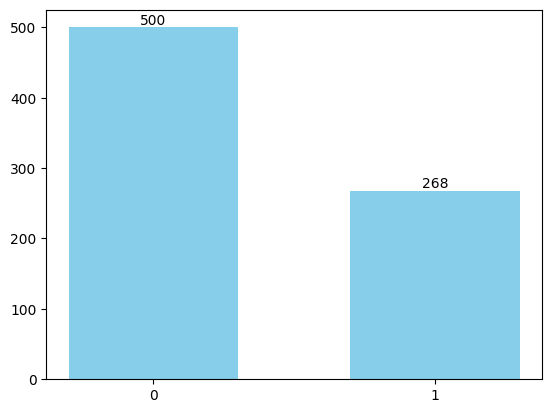

In [7]:
number_of_diabetes = np.array(data['Outcome'].value_counts())

x_axis_labels = np.array([data['Outcome'].unique()[1], data['Outcome'].unique()[0]])

fig, ax = plt.subplots()

diabetes_bar = ax.bar(
    x=x_axis_labels,
    height=number_of_diabetes,
    width=0.6,
    bottom=0,
    align='center',
    color='skyblue',
    facecolor='skyblue',
    tick_label=x_axis_labels
)

ax.bar_label(
    container=diabetes_bar,
    labels=number_of_diabetes,
    label_type='edge'
)

plt.show()

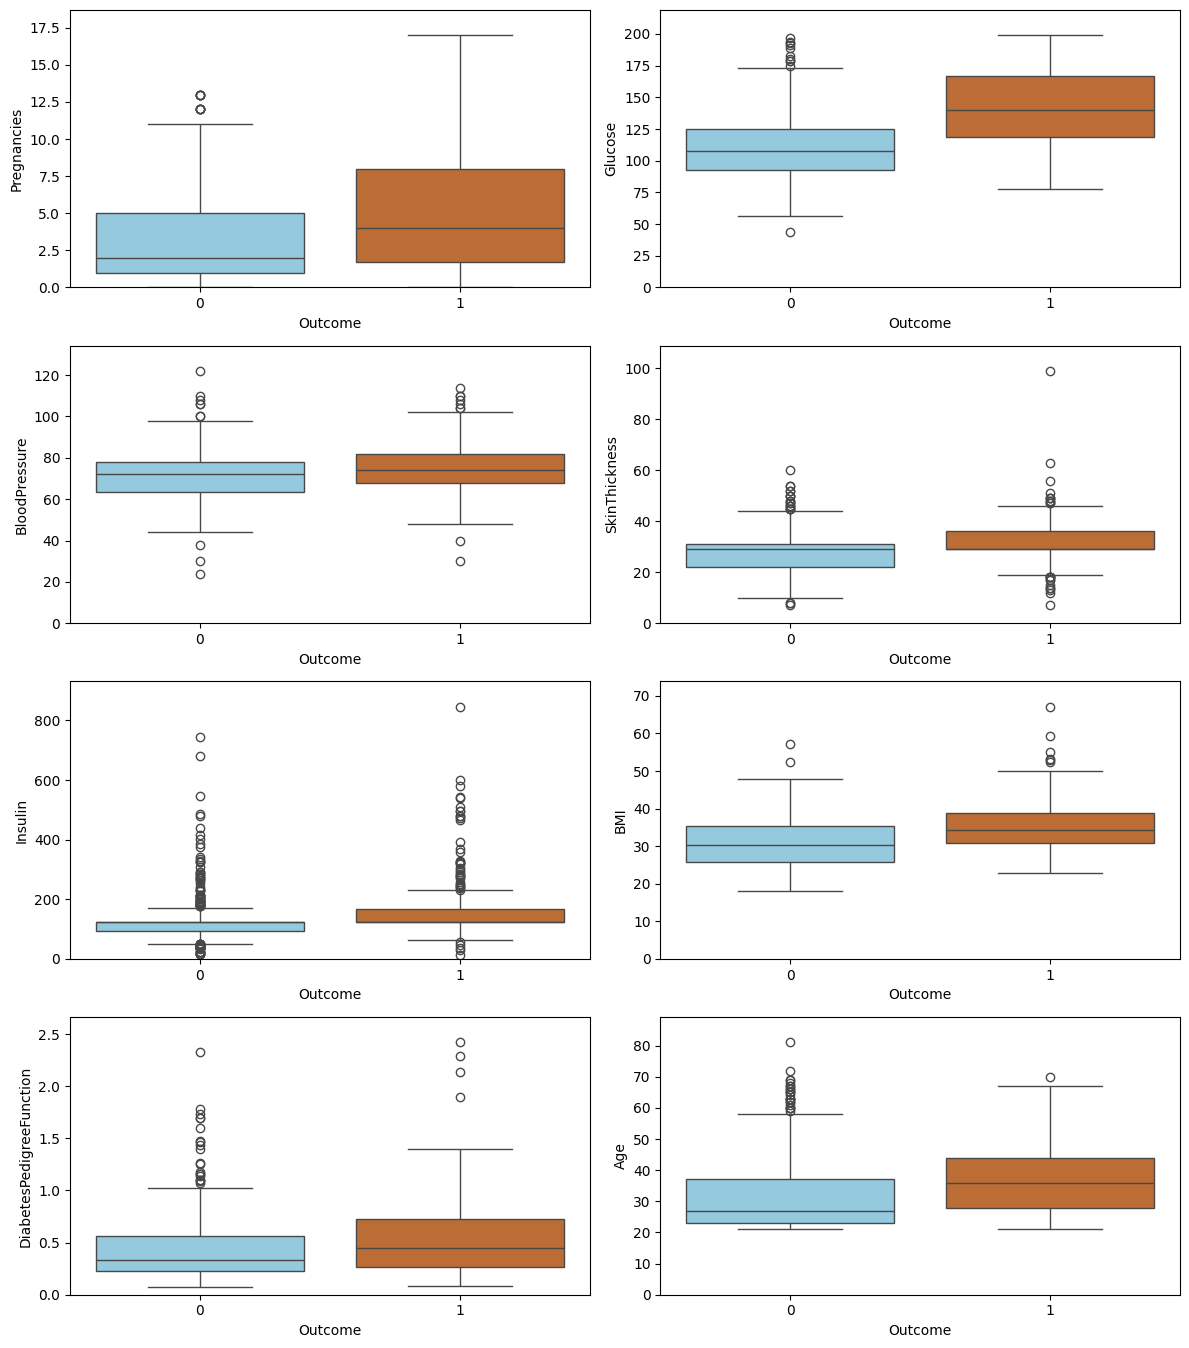

In [8]:
variables = [col for col in data.columns if col not in ['Outcome']]

# Set up 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(12, 14))
axes = axes.flatten()

# Create one boxplot per variable
for idx, var in enumerate(variables):
    sns.boxplot(
        data=data,
        x='Outcome', 
        y=var,
        hue='Outcome',
        palette={0: 'skyblue', 1: 'chocolate'},
        ax=axes[idx])
    axes[idx].set_xlabel("Outcome")
    axes[idx].set_ylabel(var)  
    axes[idx].set_ylim(bottom=0, top=1.1*max(data[var]))

    if axes[idx].get_legend():
        axes[idx].legend_.remove()

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

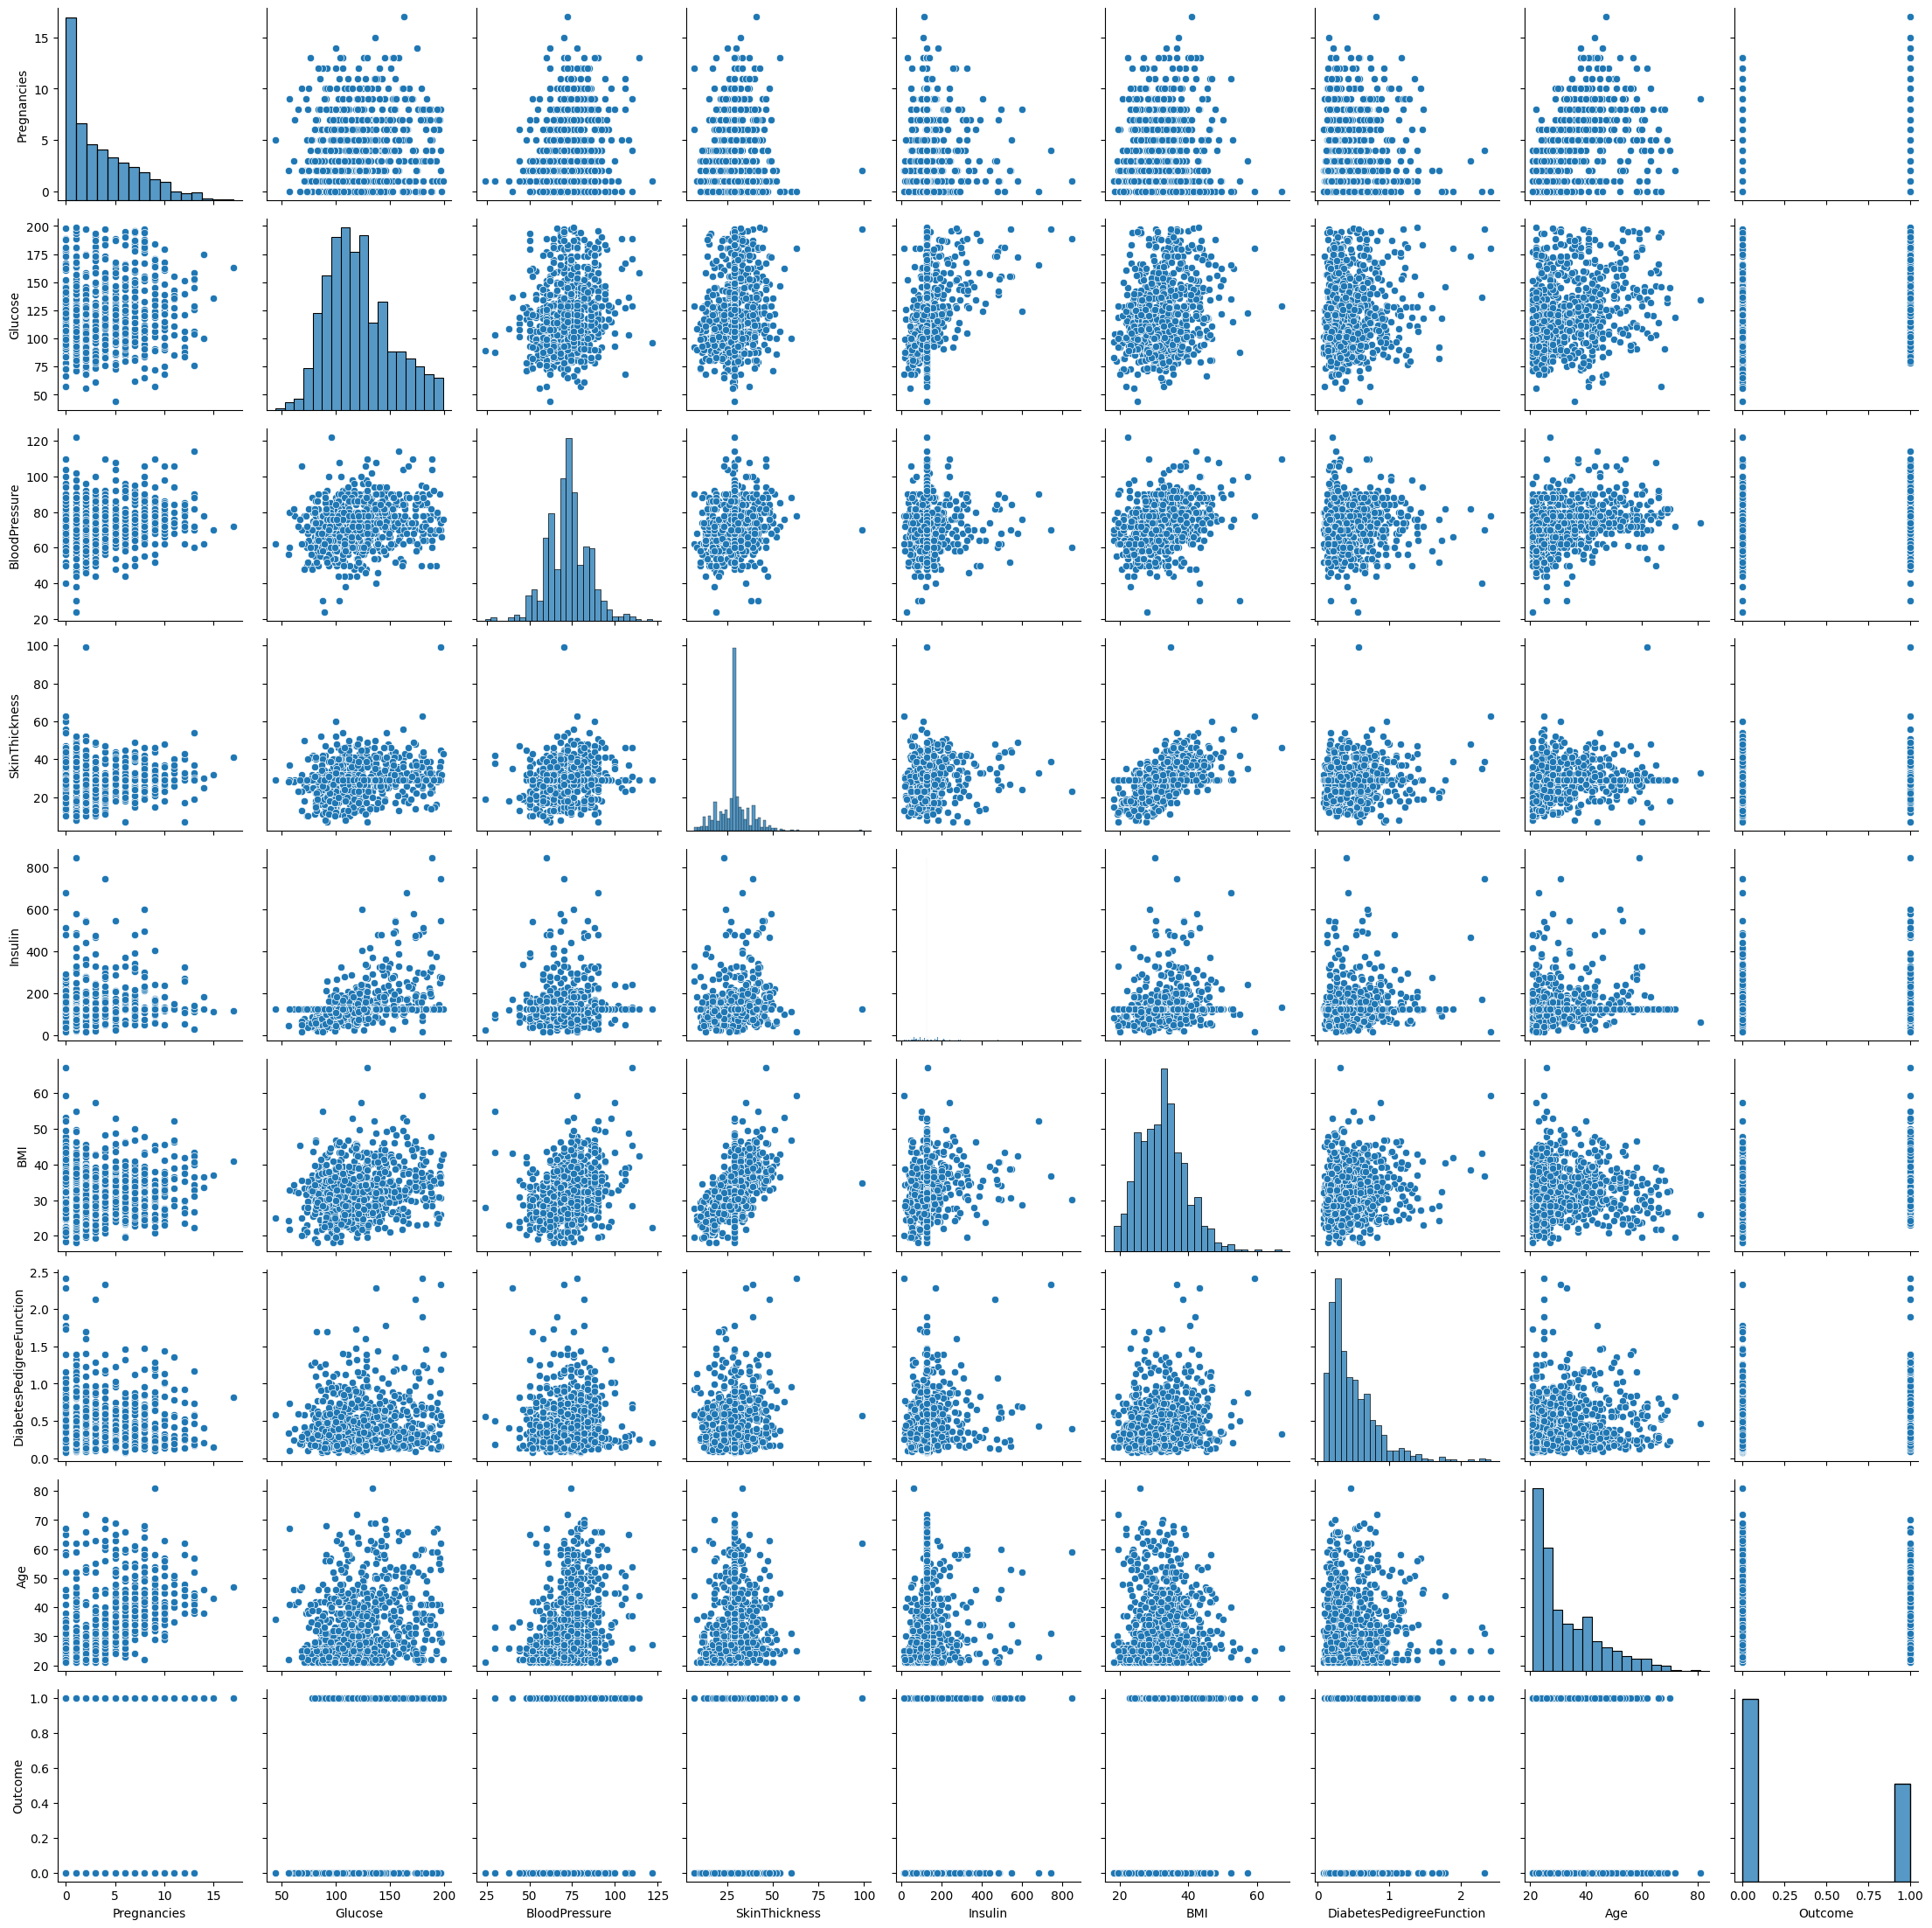

In [9]:
diabetes_grid = sns.PairGrid(data, diag_sharey=False)
diabetes_grid.map_offdiag(sns.scatterplot)
diabetes_grid.map_diag(sns.histplot)

plt.show()

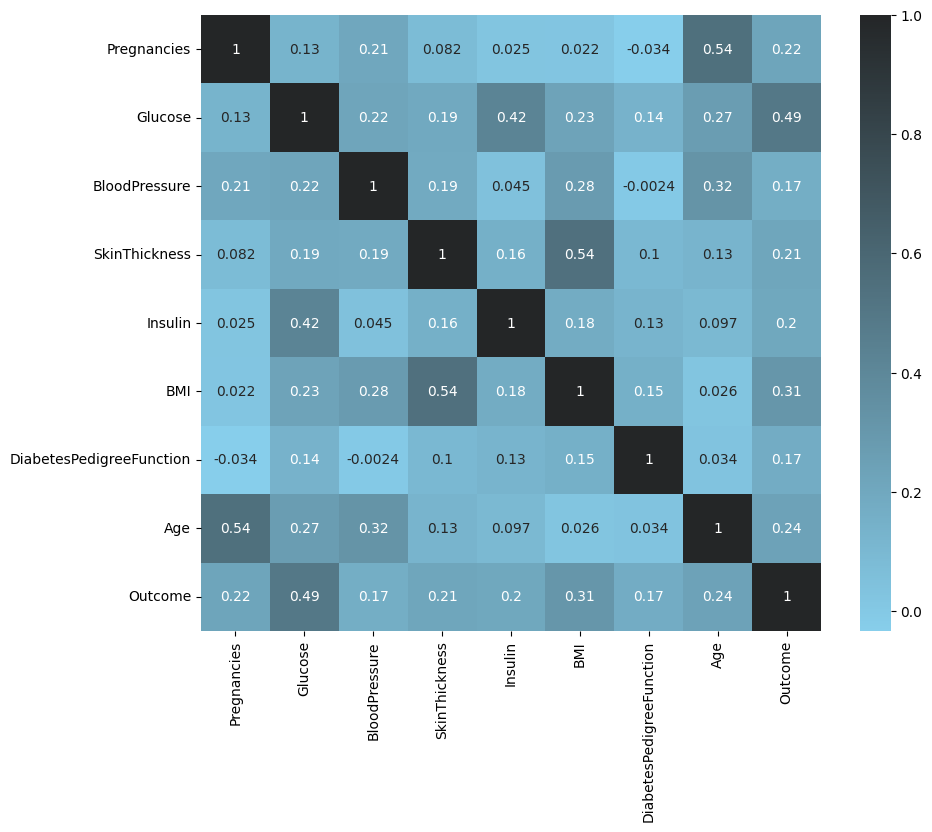

In [10]:
diabetes_corr_matrix = data.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    data=diabetes_corr_matrix, 
    annot=True, 
    cmap=sns.dark_palette(
        color='skyblue', 
        reverse=True, 
        as_cmap=True
    )
)

plt.show()

The variable Outcome has a positive correlation with all the features. Therefore, when the variable Outcome has a value of 1, the mean of the features is higher. In other words, the mean of the features for diabetic women is higher than for non-diabetic women. 

In [47]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=50, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=50, stratify=y_temp)

In [48]:
print('Class proportions in the training set:')
print(round(y_train.value_counts()*100/y_train.value_counts().sum(), 2))
print('\nClass proportions in the validation set:')
print(round(y_val.value_counts()*100/y_val.value_counts().sum(), 2))
print('\nClass proportions in the test set:')
print(round(y_test.value_counts()*100/y_test.value_counts().sum(), 2))

Class proportions in the training set:
Outcome
0    65.18
1    34.82
Name: count, dtype: float64

Class proportions in the validation set:
Outcome
0    65.22
1    34.78
Name: count, dtype: float64

Class proportions in the test set:
Outcome
0    64.66
1    35.34
Name: count, dtype: float64


In [49]:
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [50]:
def train_gbc(X_train, y_train):
    # Creating the pipeline
    pipe = Pipeline(
        steps=[
            ('scaler', MinMaxScaler()),
            ('gbc', GradientBoostingClassifier(random_state=50))
        ]
    )
    # Creating the param_grid 
    param_grid = {
        'gbc__loss': ['log_loss', 'exponential'],
        'gbc__learning_rate': np.linspace(0.001, 0.1, 10, dtype=float)
        #'gbc__n_estimators': [100, 200, 300],
        #'gbc__max_depth': [2, 3, 4]
    }
    # Creating object that will check the hyperparameters values
    model_cv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1
    )
    # Training the model using the GridSearchCV to find the best values for each hyperparameter
    model = model_cv.fit(X=X_train, y=y_train)
    # Showing the optimal values
    print(model.best_estimator_)
    # Making a copy of the pipeline with the optimal values of the hyperparameters
    model_copy = model.best_estimator_
    # Training the classifier again with the optimal values of the hyperparameters
    model = model_copy.fit(X=X_train, y=y_train)

    return model


In [51]:
def calculate_scores(model, X_val, y_val):
    # Calculating the predictions for the test set
    y_val_pred = model.predict(X_val)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    print("Confusion Matrix")
    display = ConfusionMatrixDisplay(conf_matrix)
    display.plot()
    plt.show()

    # Calculating prediction scores 

    # Accuracy
    acc = round(accuracy_score(y_val, y_val_pred), 2)
    print(f"\nAccuracy: {acc}")
    # Precision
    prec = round(precision_score(y_val, y_val_pred), 2)
    print(f"\nPrecision: {prec}")
    # Recall
    recall = round(recall_score(y_val, y_val_pred), 2)
    print(f"\nRecall: {recall}")
    # Score F1
    f1 = round(f1_score(y_val, y_val_pred), 2)
    print(f"\nF1: {f1}")

In [52]:
diabetes_gbc = train_gbc(
    X_train=X_train,
    y_train=y_train
)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=np.float64(0.034),
                                            random_state=50))])


Confusion Matrix


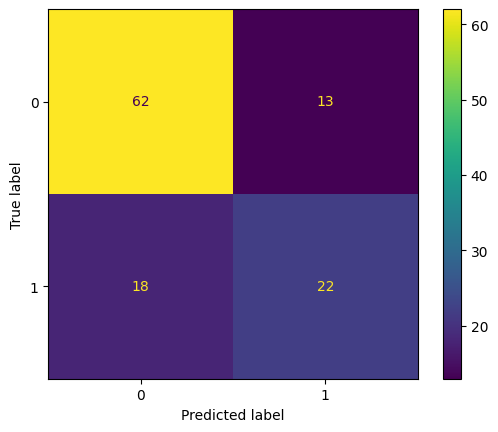


Accuracy: 0.73

Precision: 0.63

Recall: 0.55

F1: 0.59


In [53]:
diabetes_gbc_scores = calculate_scores(
    model=diabetes_gbc,
    X_val=X_val,
    y_val=y_val
)

In [54]:
joblib.dump(value=diabetes_gbc, filename='model.pkl')

['model.pkl']